# Adding topography to geological models
***
This chapter shows how to make geological models look more realistic by incorporating topography data:
- The data can either be stored in a raster file that can be conveniently loaded into gempy.
- For demonstration purposes GemPy also provides a tool to create a random hilly landscape to limit the models on the surface.

***

In [1]:
import sys
sys.path.append("../..")

import gempy as gp
import numpy as np
import matplotlib.pyplot as plt
import os

no gdal


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### 1. The common procedure to set up a model:

In [2]:
geo_model = gp.create_model('Tutorial_ch1-7_Single_layer_topo')

gp.init_data(geo_model, extent=[440720, 441129, 69280,69689,-200,250],resolution = (50,50,50),
                         path_i = os.pardir+"/data/input_data/tut-ch1-7/onelayer_interfaces.csv",
                         path_o = os.pardir+"/data/input_data/tut-ch1-7/onelayer_orient.csv")



Tutorial_ch1-7_Single_layer_topo  2019-04-30 15:04

In [3]:
# use happy spring colors! 
geo_model.surfaces.colors.change_colors({'layer1':'#ff8000','basement':'#88cc60'})

,surface,series,order_surfaces,isBasement,color,id
0,layer1,Default series,1,False,#ff8000,1
1,basement,Basement,1,True,#88cc60,2


In [4]:
%matplotlib inline
gp.map_series_to_surfaces(geo_model, {'series':('layer1','basement')})

,surface,series,order_surfaces,isBasement,color,id
0,layer1,series,1,False,#ff8000,1
1,basement,series,2,True,#88cc60,2


### 2. Adding topography

#### 2.b create fun topography

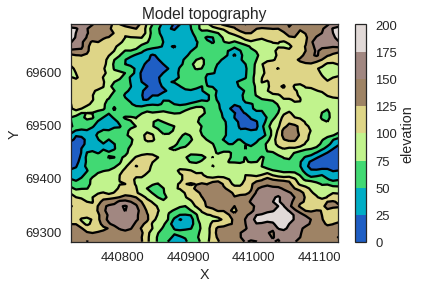

In [4]:
geo_model.set_topography(d_z=np.array([0,200]))

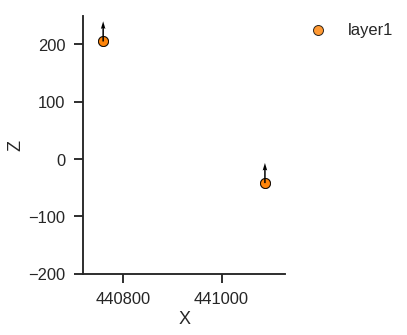

In [6]:
gp.plot.plot_data(geo_model)

#### 2 a. Load from raster file

In [7]:
fp = os.pardir+"/input_data/bogota.tif"

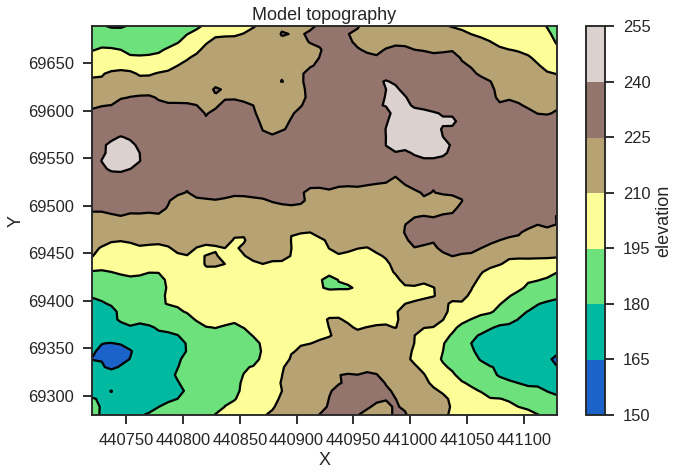

In [8]:
geo_model.set_topography()

In [9]:
vtkp = gp.plot.plot_3D(geo_model)

holding... Use vtk.resume to go back to the interactive window


In [10]:
vtkp.resume()

holding... Use vtk.resume to go back to the interactive window


In [11]:
#geo_model.grid.topography.load_from_gdal(filepath=fp)

In [12]:
#geo_model.set_topography(source='gdal',filepath=fp)

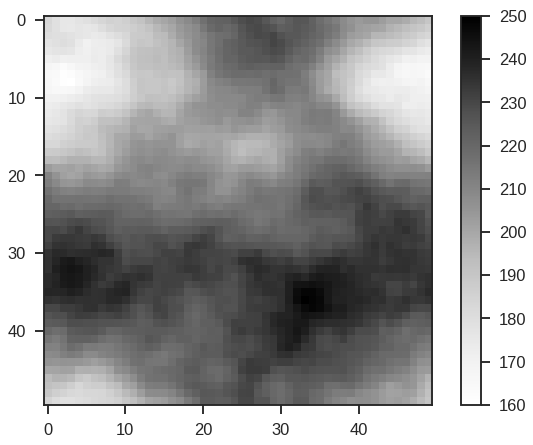

In [13]:
plt.imshow(geo_model.grid.topography.topo.dem_zval)
plt.colorbar()

In [5]:
gp.set_interpolation_data(geo_model,
                          output='geology', compile_theano=True,
                          theano_optimizer='fast_compile')

Compiling theano function...
Compilation Done!


,values
dtype,float64
output,geology
theano_optimizer,fast_compile
device,cpu
verbosity,[]


In [6]:
geo_model.grid.regular_grid.mask_topo.shape

(50, 50, 50)

In [7]:
geo_model

Tutorial_ch1-7_Single_layer_topo  2019-04-30 15:04

In [8]:
gp.compute_model(geo_model)


Lithology ids 
  [2. 2. 2. ... 1. 1. 1.] 

In [9]:
vtkp = gp.plot.plot_3D(geo_model)

holding... Use vtk.resume to go back to the interactive window


In [10]:
vtkp.set_real_time_on()

In [ ]:
vtkp.update_model()

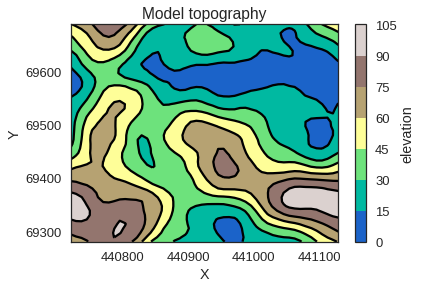

In [17]:
geo_model.set_topography(d_z=np.array([0,100]), fd=0.9, plot_object= vtkp)

In [ ]:
geo_model.solutions.mask_matrix

array([[ True,  True,  True, ...,  True,  True,  True]])

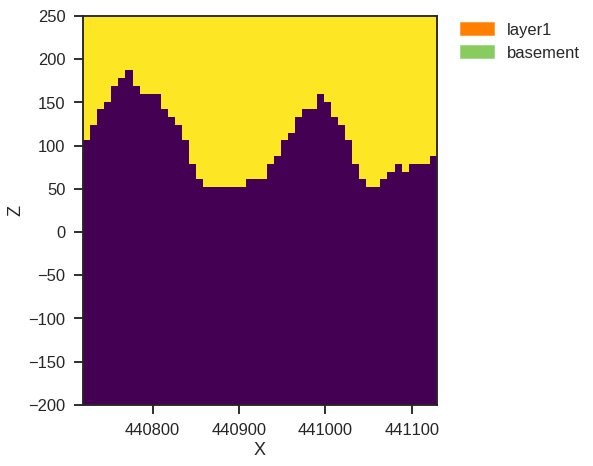

In [ ]:
gp.plot.plot_section(geo_model, 25, direction='y', block=geo_model.grid.regular_grid.mask_topo,
                show_topo=False)

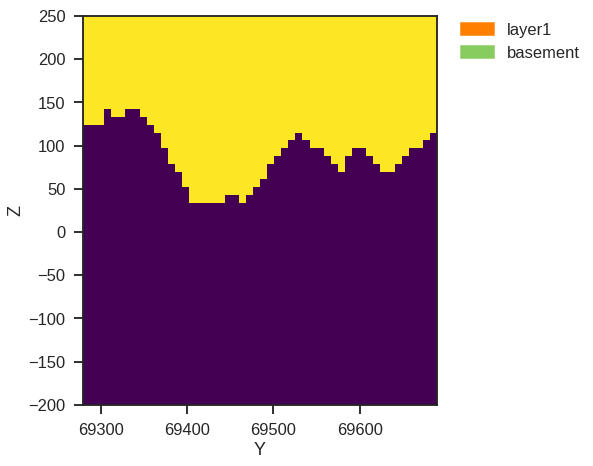

In [ ]:
gp.plot.plot_section(geo_model, 25, direction='x', block=geo_model.grid.regular_grid.mask_topo,
                show_topo=False)


In [ ]:
vtkp = gp.plot.plot_3D(geo_model)

Exception ignored in: <module 'threading' from '/home/miguel/anaconda3/lib/python3.6/threading.py'>
Traceback (most recent call last):
  File "/home/miguel/anaconda3/lib/python3.6/threading.py", line 1289, in _shutdown
    assert tlock.locked()
SystemError: <built-in method locked of _thread.lock object at 0x7fc584e94a30> returned a result with an error set


In [ ]:
import vtk

colors = vtk.vtkNamedColors()
# Create points on an XY grid with random Z coordinate
vertices = geo_model.grid.topography.values

points = vtk.vtkPoints()
for v in vertices:
    v[-1] =  v[-1]
    points.InsertNextPoint(v)

# Add the grid points to a polydata object
polydata = vtk.vtkPolyData()
polydata.SetPoints(points)

glyphFilter = vtk.vtkVertexGlyphFilter()
glyphFilter.SetInputData(polydata)
glyphFilter.Update()

# Create a mapper and actor
pointsMapper = vtk.vtkPolyDataMapper()
pointsMapper.SetInputConnection(glyphFilter.GetOutputPort())

pointsActor = vtk.vtkActor()
pointsActor.SetMapper(pointsMapper)
pointsActor.GetProperty().SetPointSize(3)
pointsActor.GetProperty().SetColor(colors.GetColor3d("Red"))

# Triangulate the grid points
delaunay = vtk.vtkDelaunay2D()
delaunay.SetInputData(polydata)
delaunay.Update()

# Create a mapper and actor
triangulatedMapper = vtk.vtkPolyDataMapper()
triangulatedMapper.SetInputConnection(delaunay.GetOutputPort())

triangulatedActor = vtk.vtkActohr()
triangulatedActor.SetMapper(triangulatedMapper)

# # Create a renderer, render window, and interactor
# renderer = vtk.vtkRenderer()
# renderWindow = vtk.vtkRenderWindow()
# renderWindow.AddRenderer(renderer)
# renderWindowInteractor = vtk.vtkRenderWindowInteractor()
# renderWindowInteractor.SetRenderWindow(renderWindow)

# # Add the actor to the scene
# renderer.AddActor(pointsActor)
# renderer.AddActor(triangulatedActor)
# renderer.SetBackground(colors.GetColor3d("Green")) # Background color green

# # Render and interact
# renderWindow.Render()
# renderWindowInteractor.Start()

In [ ]:
vtkp.ren_list[0].AddActor(triangulatedActor)

In [ ]:
vtkp.render_surfaces()

In [ ]:
vtkp.resume()

In [ ]:
break

In [ ]:
vtkp.resume()

In [ ]:
import vtk

In [ ]:
surf_polydata = vtk.vtkPolyData()
surf_polydata.SetPoints(points)


delny = vtk.vtkDelaunay2D()
delny.SetInputData(profile)
delny.SetTolerance(0.001)

elev = vtk.vtkElevationFilter()
elev.SetInputConnection(tri.GetOutputPort())

surf_polydata.SetPolys(delny)

In [ ]:
surf_polydata.Set

In [ ]:
import vtk
# Create topography plane
vertices = geo_model.grid.topography.values

points = vtk.vtkPoints()
for v in vertices:
    v[-1] =  v[-1]
    points.InsertNextPoint(v)
points
# profile = vtk.vtkPolyData()
# profile.SetPoints(points)

In [ ]:
colors = vtk.vtkNamedColors()

profile = vtk.vtkPolyData()
profile.SetPoints(points)


delny = vtk.vtkDelaunay2D()
delny.SetInputData(profile)
delny.SetTolerance(0.001)

In [ ]:
i = vtkp.ren_list[0]


In [ ]:
vtkp.create_surface()

In [ ]:
cowNormals = vtk.vtkPolyDataNormals()
cowNormals.SetInputConnection(s2.GetOutputPort())

In [ ]:
tri = delny
# vtkImplicitDataSet needs some scalars to interpolate to find inside/outside
elev = vtk.vtkElevationFilter()
elev.SetInputConnection(tri.GetOutputPort())
mapper2 = vtk.vtkDataSetMapper()
mapper2.SetInputConnection(elev.GetOutputPort())
actor2 = vtk.vtkActor()
actor2.SetMapper(mapper2)

In [ ]:
ren1 = vtk.vtkRenderer()
renWin = vtk.vtkRenderWindow()
renWin.AddRenderer(ren1)
iren = vtk.vtkRenderWindowInteractor()
iren.SetRenderWindow(renWin)
 
renWin.Render()
iren.Start()

In [ ]:
sol2 = gp.compute_model_at(geo_model.grid.topography.values, geo_model, compute_mesh=False)

In [ ]:
from gempy.plot.visualization_2d import PlotData2D

In [ ]:
plot=PlotData2D(geo_model)

In [ ]:
plot.plot_map(sol2)

In [ ]:
geo_model.grid.

In [ ]:
geo_model.surfaces.modify_order_surfaces(1,0)

In [ ]:
sol = gp.compute_model(geo_model, compute_mesh=False)

In [ ]:
sol.lith_block.shape

In [ ]:
geo_model.series

In [ ]:
geo_model.surfaces

In [ ]:
import copy

In [ ]:
old_grid = copy.copy(geo_model.grid)

In [ ]:
old_grid.values.shape

In [ ]:
sol = gp.compute_model_at(old_grid.values, geo_model, compute_mesh=False)

In [ ]:
geo_model.interpolator.set_initial_results_matrices()

In [ ]:
sol.grid.values.shape

In [ ]:
geo_model.solutions.grid.resolution

In [ ]:
sol2.lith_block.shape

In [ ]:
plt.imshow(sol2.lith_block.reshape(50,50),origin='upper')

In [ ]:
sol2.grid.values.shape

In [ ]:
%matplotlib inline
gp.plot.plot_section(geo_model, cell_number=42, block=geo_model.solutions.lith_block,
                         direction='y', plot_data=True,show_faults=False)

In [ ]:
geo_model.topography._line_in_section()